In [3]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastcore.parallel import *

In [4]:
import torch
import glob2, numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/My Drive/Colab Projects/BioDiversity Project

/content/drive/My Drive/Colab Projects/BioDiversity Project


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
data_dir = "final/species"

In [8]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Projects/BioDiversity Project/data/behavior_predictions.csv")

In [9]:
df.shape

(20411, 3)

In [10]:
# Filter the DataFrame to keep records with less than four slashes
df = df[df['Image_Path'].str.count('/') < 4]

In [11]:
df.shape

(19995, 3)

In [42]:
#Specify the path where you want to save the CSV file
#output_file_path = 'filtered_data.csv'

# Save df1 as a CSV file
#df1.to_csv(output_file_path, index=False)

In [12]:
df.isnull().sum()

Image_Path             0
Species_Name           0
Behavior_Prediction    0
dtype: int64

In [13]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(add_na = True)),  # Use MultiCategoryBlock for behavior classification
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_x=ColReader('Image_Path'),
    get_y=ColReader(['Species_Name', 'Behavior_Prediction']),  # Behavior and species labels are based on the parent directory
    item_tfms=Resize(300),
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats),
    ]
)

In [14]:
dls = dblock.dataloaders(df, bs=32)

In [30]:
batch = dls.train.one_batch()

# Extract images and labels from the batch
images, labels = batch

print("Image dimensions:", images.shape)
print("Label dimensions:", labels.shape)

Image dimensions: torch.Size([32, 3, 300, 300])
Label dimensions: torch.Size([32, 110])


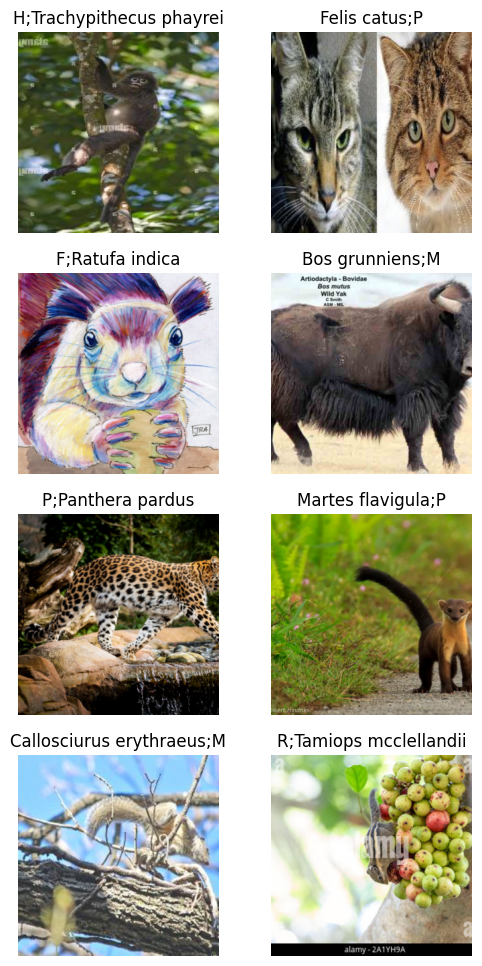

In [46]:
dls.train.show_batch(max_n = 8, nrows = 4)

In [30]:
dls.valid.vocab

['#na#', 'Acinonyx jubatus', 'Ailurus fulgens', 'Antilope cervicapra', 'Aonyx cinereus', 'Arctictis binturong', 'Axis porcinus', 'Bos frontalis', 'Bos grunniens', 'Bos taurus', 'Boselaphus tragocamelus', 'Bubalus bubalis', 'Budorcas taxicolor', 'Callosciurus erythraeus', 'Canis aureus', 'Canis lupus', 'Capra falconeri', 'Capra sibirica', 'Caracal caracal', 'Catopuma temminckii', 'Cervus elaphus', 'Cuon alpinus', 'Cynopterus sphinx', 'Dicerorhinus sumatrensis', 'Elephas maximus', 'Equus hemionus', 'Equus kiang', 'F', 'Felis catus', 'Felis chaus', 'Felis manul', 'Felis silvestris', 'Funambulus palmarum', 'Funambulus pennantii', 'Gazella bennettii', 'H', 'Helarctos malayanus', 'Hemitragus jemlahicus', 'Herpestes edwardsi', 'Herpestes javanicus', 'Herpestes smithii', 'Herpestes urva', 'Herpestes vitticollis', 'Hipposideros ater', 'Hipposideros speoris', 'Hoolock hoolock', 'Hyaena hyaena', 'Kerivoula picta', 'Lepus nigricollis', 'Loris lydekkerianus', 'Lutra lutra', 'Lutrogale perspicillata

In [31]:
dls.train.vocab

['#na#', 'Acinonyx jubatus', 'Ailurus fulgens', 'Antilope cervicapra', 'Aonyx cinereus', 'Arctictis binturong', 'Axis porcinus', 'Bos frontalis', 'Bos grunniens', 'Bos taurus', 'Boselaphus tragocamelus', 'Bubalus bubalis', 'Budorcas taxicolor', 'Callosciurus erythraeus', 'Canis aureus', 'Canis lupus', 'Capra falconeri', 'Capra sibirica', 'Caracal caracal', 'Catopuma temminckii', 'Cervus elaphus', 'Cuon alpinus', 'Cynopterus sphinx', 'Dicerorhinus sumatrensis', 'Elephas maximus', 'Equus hemionus', 'Equus kiang', 'F', 'Felis catus', 'Felis chaus', 'Felis manul', 'Felis silvestris', 'Funambulus palmarum', 'Funambulus pennantii', 'Gazella bennettii', 'H', 'Helarctos malayanus', 'Hemitragus jemlahicus', 'Herpestes edwardsi', 'Herpestes javanicus', 'Herpestes smithii', 'Herpestes urva', 'Herpestes vitticollis', 'Hipposideros ater', 'Hipposideros speoris', 'Hoolock hoolock', 'Hyaena hyaena', 'Kerivoula picta', 'Lepus nigricollis', 'Loris lydekkerianus', 'Lutra lutra', 'Lutrogale perspicillata

In [21]:
na_count = (df['Species_Name'] == '#na#').sum()

print("Number of records with '#na#' label:", na_count)

Number of records with '#na#' label: 0


In [15]:
train_len = len(dls.train)
valid_len = len(dls.valid)

print(f"Training DataLoader Length: {train_len}")
print(f"Validation DataLoader Length: {valid_len}")

Training DataLoader Length: 499
Validation DataLoader Length: 125


In [16]:
model_path = "models"

In [17]:
from fastai import metrics
model = vision_learner(dls, resnet101, metrics=[accuracy_multi, F1ScoreMulti(), PrecisionMulti()])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
model.freeze()

SuggestedLRs(slide=0.019054606556892395, valley=0.0020892962347716093)

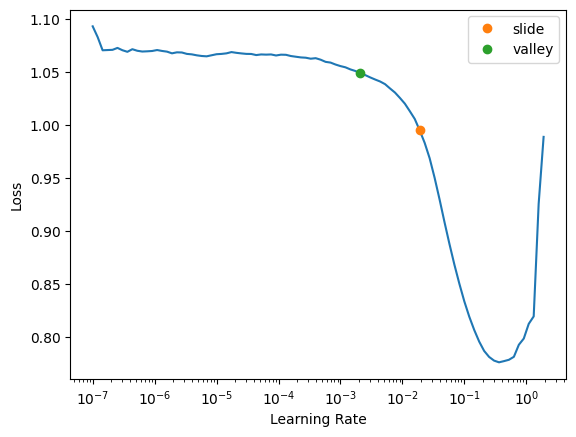

In [19]:
model.lr_find(suggest_funcs=[slide, valley])

In [20]:
import math

slide = 0.019054606556892395
valley = 0.0020892962347716093

log_slide = math.log10(slide)
log_valley = math.log10(valley)

lr_max = slice(10**(log_valley), 10**(log_slide))

lr_max

slice(0.0020892962347716097, 0.019054606556892402, None)

In [21]:
model.fit_one_cycle(2, lr_max = lr_max)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.043950,0.036005,0.986606,0.512644,0.757470,11:16
1,0.031856,0.027014,0.989518,0.672141,0.852524,06:09


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/di

In [23]:
model.unfreeze()

SuggestedLRs(slide=0.02290867641568184, valley=3.630780702224001e-05)

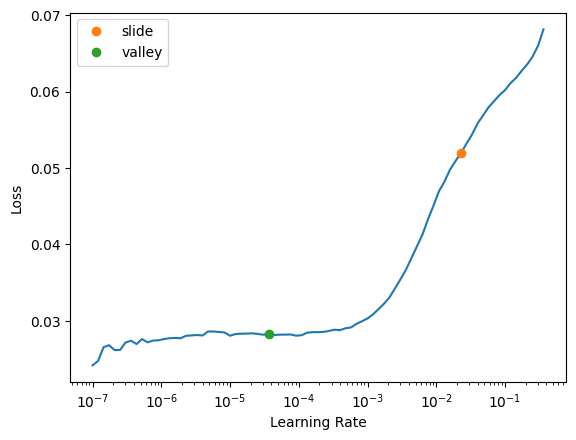

In [24]:
from fastai.callback.schedule import slide, valley

model.lr_find(suggest_funcs=[slide, valley])

In [25]:
import math

slide = 0.02290867641568184
valley = 3.630780702224001e-05

log_slide = math.log10(slide)
log_valley = math.log10(valley)

lr_max = slice(10**(log_valley), 10**(log_slide))

lr_max

slice(3.630780702224002e-05, 0.02290867641568184, None)

In [26]:
model.fit_one_cycle(5, lr_max = lr_max)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.048781,0.050737,0.983539,0.276858,0.538531,08:09
1,0.044932,0.041445,0.985399,0.450462,0.675852,08:17
2,0.036563,0.032543,0.987701,0.577029,0.800912,08:17
3,0.026408,0.025733,0.990120,0.723007,0.839641,08:17
4,0.020471,0.024824,0.990407,0.735815,0.843947,08:17


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/di

In [27]:
model.save("final-v0")

Path('models/final-v0.pth')

In [28]:
model.export("models/final-v0.pkl")